# Scoring and FDR calculation with Sagepy

The following notebook contains a basic scoring example with `sagepy`. You will:

* Create a Sage peptide reference database with decoys from a .fasta file
* Read in an mzML file from a DDA LC-MS-MS dataset and extract precursor information as well as fragment spectra
* Score the raw data and compare scores of target and decoy hits
* Calculate False Discovery Rate (FDR) q-values for each PSM using Target Decoy Competition (TDC)

The tutorial was tested with raw data from the [proteometools dataset](http://www.proteometools.org/) and used the [ThermoRawFileParser](https://github.com/compomics/ThermoRawFileParser) to translate .raw files to mzML, but feel free to use any thermo LC-MS-MS raw data stored as mzML.

## Create a sage reference database

In [1]:
import pandas as pd

from sagepy.utility import create_sage_database

fasta_path = "/path/to/proteome.fasta"

# define the modifications you want to include into the search space
# static mods need to be given as key value pairs of the amino acid and the modification that should be applied
static_mods = {
    # Carbamidomethylation C
    "C": "[UNIMOD:4]"
}

# variable mods should be given as key value pairs of the amino acids and a list of all modifications that should be applied to them
# [X, ]X mean PROTEIN N and C terminal modification applied to amino acid X;
# ^X, $X mean PEPTIDE  N and C terminal modification applied to amino acid X;
variable_mods = {
    # any M should also be generated with UNIMOD:35 (Oxidation)
    "M": ["[UNIMOD:1]", "[UNIMOD:35]"], 
    # Protein N-terminal M should als be generated with UNIMOD:1 (Acetylation) 
    "[M": ["[UNIMOD:1]"]
}

# for simplicity, we can use the create_sage_database function, that creates a sage indexed database with tryptic settings
indexed_database = create_sage_database(
    fasta_path = fasta_path,
    static_mods = static_mods,
    variable_mods = variable_mods
)

## Read an mzML file

In [2]:
from sagepy.utility import extract_mzml_data

mzml_path = "/path/to/dda/raw/data.mzML"

# this function expects thermo data and was tested with proteome tools datasets
dda_data = extract_mzml_data(
    file_path=mzml_path
)

## Create a Sage Scorer and Score a collection of spectra

In [3]:
from sagepy.core import Scorer

scorer = Scorer(report_psms=5, min_matched_peaks=5, static_mods=static_mods, variable_mods=variable_mods)

# the scorer returns a dict of type PeptideSpectrumMatch, an object that holds information about the PSM
# where the types are Dict[spec_id -> List[PSM]]
psms = scorer.score_collection_psm(
    db=indexed_database, 
    spectrum_collection=dda_data.processed_spec.values,
    num_threads=12
)

## Create a pandas table holding all PSMs found during the DB search

In [4]:
from sagepy.utility import peptide_spectrum_match_collection_to_pandas

# this helper function creates a pandas table from a list of PSM objects
PSM_pandas = peptide_spectrum_match_collection_to_pandas(psms)

## Plot the scores for target and decoy hits

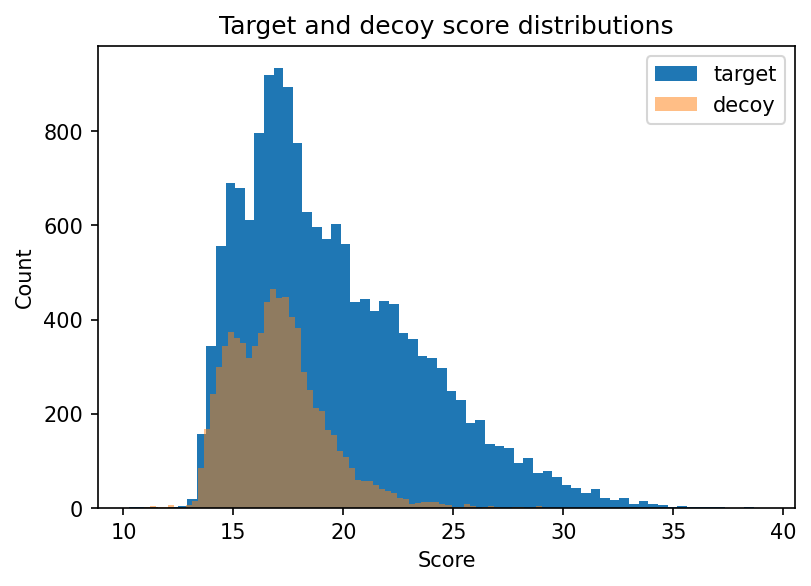

In [5]:
from matplotlib import pyplot as plt

TARGET = PSM_pandas[PSM_pandas.decoy == False]
DECOY = PSM_pandas[PSM_pandas.decoy]

plt.figure(figsize=(6, 4), dpi=150)

plt.hist(TARGET.hyper_score, bins="auto", label="target")
plt.hist(DECOY.hyper_score, bins="auto", alpha=.5, label="decoy")
plt.legend()
plt.title("Target and decoy score distributions")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

## Target Decoy Competition (TDC) for False Discovery Rate (FDR) estimation

It is common to use the generated raw scores from the PSMs as a test statistic, transforming the raw scores into q-values. If you are unfamiliar with this concept, there are [several resources](https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/10.1002/pmic.202300084?af=R) and [publications](https://pubs.acs.org/doi/full/10.1021/acs.jproteome.7b00170) available that help to understand how false discovery rates are calculated in high-throughput proteomics.

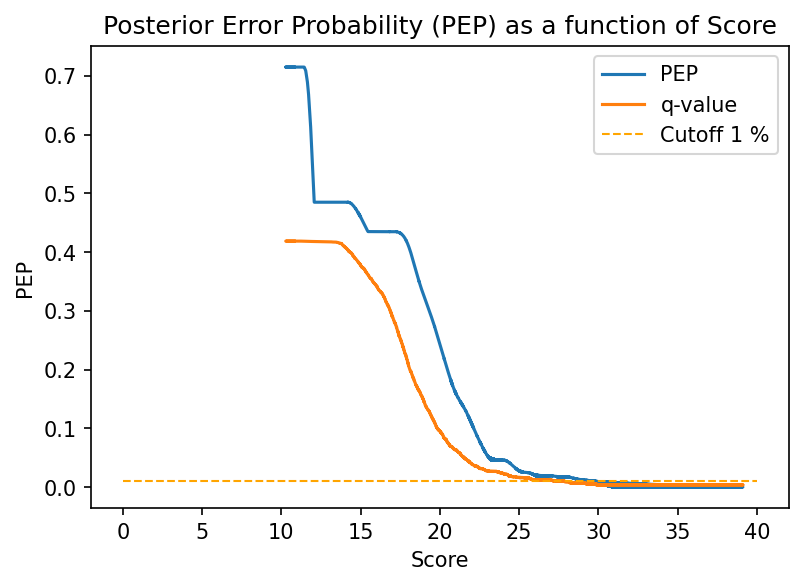

In [20]:
from sagepy.qfdr.tdc import target_decoy_competition_pandas
from sagepy.core.ml.pep import calculate_pep

TDC = target_decoy_competition_pandas(
    df=PSM_pandas,
    # the method for TDC can be set here, e.g., PSM level, peptide level, or double competition (PSM and peptide level)
    method="psm",
    score="hyper_score"
)

# add PEP to the PSMs
TDC["pep"] = calculate_pep(
    scores=TDC.score.values,
    decoys=TDC.decoy.values,
)

# Plot the PEP and Q values
plt.figure(figsize=(6, 4), dpi=150)
plt.title("Posterior Error Probability (PEP) as a function of Score")
plt.plot(TDC.score, TDC.pep, label="PEP")
plt.plot(TDC.score, TDC.q_value, label="q-value")
plt.hlines(0.01, 0, 40, label="Cutoff 1 %", linestyles="dashed", linewidth=1, color="orange")
plt.xlabel("Score")
plt.ylabel("PEP")
plt.legend()
plt.show()

## Create merged result table, filtered to target FDR with TDC method of choice

In [32]:
import pandas as pd

# after target decoy competition, hits can be filtered to, e.g., 1 percent expected FDR == q-value <= 0.01
TDC_filtered = TDC[(TDC.q_value <= 0.01) & (TDC.decoy == False)]

RESULT = pd.merge(PSM_pandas.drop(columns=["q_value", "score"]), TDC_filtered, on=["spec_idx", "match_idx", "decoy"])
RESULT

,spec_idx,match_idx,proteins,decoy,re_score,hyper_score,rank,mono_mz_calculated,mono_mass_observed,mono_mass_calculated,...,cosine_similarity,mean_ppm,median_ppm,fragments_observed,fragments_predicted,projected_rt,beta_score,score,q_value,pep
0,controllerType=0 controllerNumber=1 scan=10000,ELQQVDPR,[sp|Q5DID0|UROL1_HUMAN],False,None,30.235552,1,492.759094,983.504639,983.503601,...,None,-0.112941,0.950233,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,30.235552,0.003676,0.006219
1,controllerType=0 controllerNumber=1 scan=10018,EEGAIFKK,[sp|Q9H489|TSY26_HUMAN],False,None,29.204351,1,461.255646,920.498535,920.496704,...,None,2.424821,1.763269,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,29.204351,0.006834,0.011459
2,controllerType=0 controllerNumber=1 scan=10042,VHLLQGGK,[sp|O00445|SYT5_HUMAN],False,None,28.558388,1,426.258514,850.504700,850.502502,...,None,0.295653,1.081173,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,28.558388,0.006993,0.013920
3,controllerType=0 controllerNumber=1 scan=10278,RFVEVGR,[sp|P50914|RL14_HUMAN],False,None,28.228112,1,431.748322,861.483154,861.482056,...,None,1.780106,1.652575,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,28.228111,0.006993,0.016579
4,controllerType=0 controllerNumber=1 scan=10365,RLEMYTK,[sp|Q8IZU3|SYCP3_HUMAN],False,None,29.245128,1,470.749664,939.486206,939.484802,...,None,2.607514,1.766168,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,29.245129,0.005319,0.011386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,controllerType=0 controllerNumber=1 scan=9849,RLLDGPR,[sp|Q5FWE3|PRRT3_HUMAN],False,None,29.779442,1,413.748322,825.483154,825.482056,...,None,2.533936,2.568716,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,29.779442,0.005319,0.010175
642,controllerType=0 controllerNumber=1 scan=9878,ELQQVDPR,[sp|Q5DID0|UROL1_HUMAN],False,None,30.383914,1,492.759094,983.504883,983.503601,...,None,1.579518,2.154571,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,30.383913,0.003676,0.004405
643,controllerType=0 controllerNumber=1 scan=9882,EEGAIFKK,[sp|Q9H489|TSY26_HUMAN],False,None,27.954155,1,461.255646,920.500000,920.496704,...,None,1.809719,1.500605,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,27.954155,0.009288,0.017565
644,controllerType=0 controllerNumber=1 scan=9934,VHLLQGGK,[sp|O00445|SYT5_HUMAN],False,None,29.487092,1,426.258514,850.504456,850.502502,...,None,1.954460,1.744362,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,29.487091,0.005319,0.010953
